# Исследование для отдела маркетинга




__Описание__

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые не совершат покупку в ближайшее время (в течении 90 дней). А затем уже отдел маркетинга займётся рассылкой специальных предложений этим клиентам.

__Цель__

Предсказать факт покупки в течение 90 дней.

__Данные__

1. История покупок.
2. История рекламных рассылок.
3. Датафрейм с целевым признаком.

__Задачи__

1. Изучить данные
2. Разработать полезные признаки
3. Создать модель для классификации пользователей
4. Улучшить модель и максимизировать метрику roc_auc
5. Выполнить тестирование

__План__

1. Загрузка.
2. Предобработка.
3. Исследовательский анализ.
4. Корреляционный анализ.
5. Обучение модели.
6. Анализ важности признаков.
7. Выводы.

In [45]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
!pip install catboost -q
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
!pip install phik -q
import phik
!pip install shap -q
import shap
import ast

In [46]:
!pip freeze > requirements.txt

## Загрузка

In [47]:
data_p = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/STD_M2_purchase_in_90_days/filtered_data/apparel-purchases.csv', parse_dates=['date'])
data_m = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/STD_M2_purchase_in_90_days/filtered_data/apparel-messages.csv', parse_dates=['date', 'created_at'])
data_t = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/STD_M2_purchase_in_90_days/filtered_data/apparel-target_binary.csv')

In [48]:
data_p.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [49]:
data_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [50]:
data_m.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [51]:
data_m.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Non-Null Count     Dtype         
---  ------            --------------     -----         
 0   bulk_campaign_id  12739798 non-null  int64         
 1   client_id         12739798 non-null  int64         
 2   message_id        12739798 non-null  object        
 3   event             12739798 non-null  object        
 4   channel           12739798 non-null  object        
 5   date              12739798 non-null  datetime64[ns]
 6   created_at        12739798 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [52]:
data_t.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [53]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Датафрейм с целевой переменной имеет самый небольшой размер 49849. В конечном итоге нам нужно будет соединять все 3 группы данных в один датасет, который и примет тот самый размер. Судя по информации о данных, пропусков нет. Но вполне возможно, что пропуски имеют строковый формат и тогда их не увидеть методом info().

## Предобработка

Проверим наши датасеты на предмет явных дубликатов. Удалим их при наличии.

In [54]:
data_p.duplicated().sum()

73020

In [55]:
# удаляем дубликаты, оставляя первое значение из них
data_p.drop_duplicates(keep='first', inplace=True)
data_p.duplicated().sum()

0

In [56]:
data_m.duplicated().sum()

48610

In [57]:
# удаляем дубликаты, оставляя первое значение из них
data_m.drop_duplicates(keep='first', inplace=True)
data_m.duplicated().sum()

0

In [58]:
data_t.duplicated().sum()

0

Только в датасете с целевой переменной нет явных дубликатов. Проверим сразу, а сколько уникальных значений client_id есть в каждом датасете, так как нам потом придётся соединять их в один именно по столбцу client_id.

In [59]:
data_t['client_id'].nunique()

49849

In [60]:
data_p['client_id'].nunique()

49849

In [61]:
data_m['client_id'].nunique()

53329

Как мы видим в датафреймах с таргетом и с покупками абсолютно одинаковое число уникальных клиентов, а вот в датасете с маркетинговыми рассылками их больше. Приоритетным является датасет с целевым признаком. Именно такое количество уникальных client_id и должно быть в итоговом датафрейме после объединения.

## Исследовательский анализ

### Датафрейм с покупками

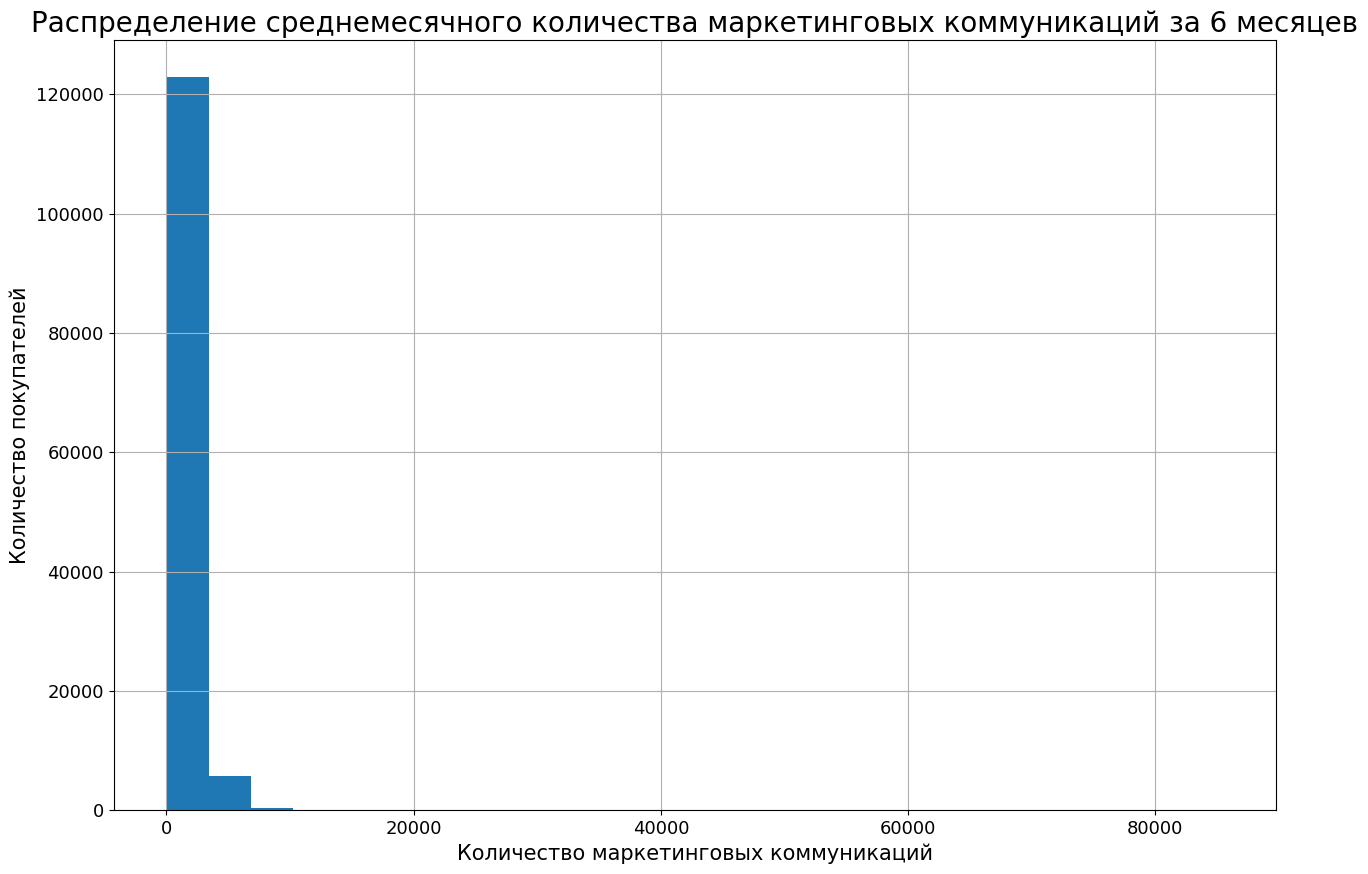

In [62]:
data_p['price'].hist(bins=25, figsize=(15, 10))
plt.title('Распределение среднемесячного количества маркетинговых коммуникаций за 6 месяцев', size=20)
plt.xlabel('Количество маркетинговых коммуникаций', size=15)
plt.ylabel('Количество покупателей', size=15)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.show()

,price
count,129188.000000
mean,1264.532766
std,1375.016339
min,1.000000
25%,399.000000
50%,999.000000
75%,1750.000000
max,85499.000000


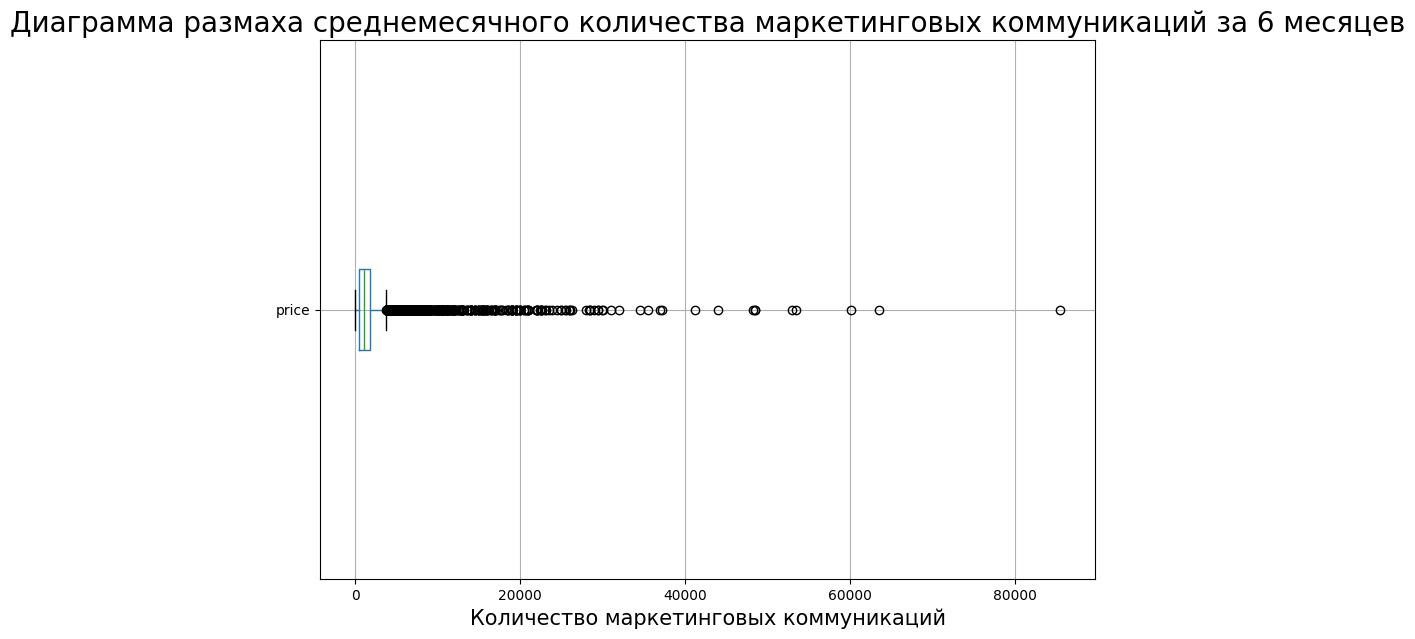

In [63]:
data_p.boxplot('price', vert=False, figsize=(10, 7))
plt.title('Диаграмма размаха среднемесячного количества маркетинговых коммуникаций за 6 месяцев', size=20)
plt.xlabel('Количество маркетинговых коммуникаций', size=15)
data_p['price'].describe()

Медианная стоимость кулпеннной единицы товара - около 1000 рублей. Как мы видим, есть и небольшое количество дорогих выбивающихся покупок вплоть до 85000 рублей. Создадим дополнительный признак с суммой, потраченной клиентом за указанное количество товара (quantity). С помощью этого столбца сделаем дополнительный признак с суммой потраченной клиентом в последнем заказе.

In [64]:
data_p['total_price'] = data_p['quantity'] * data_p['price']


# Группируем по клиенту и дате, суммируем price в каждой группе
day_purchases = data_p.groupby(['client_id', 'date'])['total_price'].sum().reset_index()

# Находим максимальную дату для каждого клиента
max_dates = day_purchases.groupby('client_id')['date'].max().reset_index()

# Объединяем с суммами за последнюю дату
last_purchase_sums = max_dates.merge(day_purchases, on=['client_id', 'date'], how='left')
last_purchase_sums = last_purchase_sums.rename(columns={'total_price': 'last_purchase_sum'})
# Проверим результат
last_purchase_sums.head()

,client_id,date,last_purchase_sum
0,1515915625468060902,2022-05-27,4795.0
1,1515915625468061003,2023-01-04,14135.0
2,1515915625468061099,2022-05-17,299.0
3,1515915625468061100,2024-02-10,1049.0
4,1515915625468061170,2023-06-17,999.0


In [65]:
last_purchase_sums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   client_id          49849 non-null  int64         
 1   date               49849 non-null  datetime64[ns]
 2   last_purchase_sum  49849 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.1 MB


Также создадим ещё один признак с количеством дней с последнего заказа клиента до предполагаемой даты формирования выборки. А именно - самая крайняя дата в датасете +1 день.

In [66]:
# Находим максимальную дату во всем DataFrame
cutoff_date = last_purchase_sums['date'].max() + pd.Timedelta(days=1)

# Вычисляем разницу в днях, используя уже имеющуюся дату из last_purchase_sums
last_purchase_sums['days_since_last_purchase'] = (cutoff_date - last_purchase_sums['date']).dt.days
# Проверим результат
last_purchase_sums.head()

,client_id,date,last_purchase_sum,days_since_last_purchase
0,1515915625468060902,2022-05-27,4795.0,631
1,1515915625468061003,2023-01-04,14135.0,409
2,1515915625468061099,2022-05-17,299.0,641
3,1515915625468061100,2024-02-10,1049.0,7
4,1515915625468061170,2023-06-17,999.0,245


Теперь рассмотрим столбец с категориями товаров. В таком виде, в котором он сейчас, от него скорее всего будет мало толку в модели.

In [67]:
data_p['category_ids'].value_counts().head(50)

,count
category_ids,
"['4', '28', '57', '431']",6191
"['4', '28', '244', '432']",4835
"['4', '28', '260', '420']",4421
"['4', '28', '275', '421']",3309
"['2', '18', '258', '441']",3175
"['4', '28', '62', '657']",2841
[],2738
"['4', '28', '124', '415']",2735
"['4', '28', '62', '656']",2485


Надо понять, а есть ли какая то иерархия в этих категориях. Проверим на примере самого частого значения ['4', '28', '57', '431'], а является ли категория 431 подкатегорией 4. Нужно проверить, всегда ли 431 встречается вместе с 4 или нет.

In [68]:
def check_category(categories, category_to_check):
    return category_to_check in categories

data_p['has_431'] = data_p['category_ids'].apply(lambda x: check_category(x, '431'))
data_p['has_4'] = data_p['category_ids'].apply(lambda x: check_category(x, '4'))

count_431_no_4 = len(data_p[(data_p['has_431'] == True) & (data_p['has_4'] == False)])

if count_431_no_4 == 0:
    print("Во всех случаях, когда присутствует '431', присутствует и '4'. Возможно, '431' является подкатегорией '4'.")
else:
    print(f"Найдено {count_431_no_4} случаев, когда '431' присутствует, а '4' — нет. '431' скорее всего не является строгой подкатегорией '4'.")

total_431 = data_p['has_431'].sum()
total_both = len(data_p[(data_p['has_431'] == True) & (data_p['has_4'] == True)])
percentage = (total_both / total_431) * 100 if total_431 > 0 else 0

print(f"'4' и '431' встречаются вместе в {percentage:.2f}% случаев")

Во всех случаях, когда присутствует '431', присутствует и '4'. Возможно, '431' является подкатегорией '4'.
'4' и '431' встречаются вместе в 100.00% случаев


С большой вероятностью слева находится главная категория. Примем решение оставить только её в этом столбце, а все пропуски заполнить заглушкой 'unknown'.

In [69]:
def extract_first_element(text):
    """Извлекает первый элемент из строки, представляющей список, или возвращает 'unknown' при ошибке."""
    if text == '[None]':
        return 'unknown'  # Обработка None значений
    try:
        if isinstance(text, str) and text.strip():
            text = text.strip('[]').replace("'", "").strip()
            if text:
                return text.split(',')[0]
            else:
                return 'unknown'  # Пустая строка
        else:
            return 'unknown'  # Не строка или пустая строка
    except (ValueError, IndexError, AttributeError):
        return 'unknown'

data_p['category_ids'] = data_p['category_ids'].apply(extract_first_element)
data_p.head()

,client_id,quantity,price,category_ids,date,message_id,total_price,has_431,has_4
0,1515915625468169594,1,1999.0,4,2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,True,True
1,1515915625468169594,1,2499.0,4,2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0,True,True
2,1515915625471138230,1,6499.0,4,2022-05-16,1515915625471138230-4437-6282242f27843,6499.0,True,True
3,1515915625471138230,1,4999.0,4,2022-05-16,1515915625471138230-4437-6282242f27843,4999.0,False,True
4,1515915625471138230,1,4999.0,4,2022-05-16,1515915625471138230-4437-6282242f27843,4999.0,False,True


In [70]:
data_p['category_ids'].value_counts()

,count
category_ids,
4,73428
5562,29148
2,17995
6060,4458
unknown,3360
5963,789
3,6
1,3
5,1


In [71]:
data_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129188 entries, 0 to 202207
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     129188 non-null  int64         
 1   quantity      129188 non-null  int64         
 2   price         129188 non-null  float64       
 3   category_ids  129188 non-null  object        
 4   date          129188 non-null  datetime64[ns]
 5   message_id    129188 non-null  object        
 6   total_price   129188 non-null  float64       
 7   has_431       129188 non-null  bool          
 8   has_4         129188 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 8.1+ MB


Как мы видим, уникальных главных категорий совсем немного. Посмотрим потом, помогут ли они модели сделать предсказание.

Теперь приступим к группировке датасета по столбцу client_id, формируя при этом столбцы с общей суммой потраченной клиентом, самой частой категорией покупок клиента, количеством отправленных клиенту маркетинговых сообщений, а также общим количеством заказов (подразумевая, что в один день, клиент не делал более одного заказа). А далее мы соединим этот датафрейм с нашим временным датасетом с суммой последнего заказа и количеством дней с последнего заказа.

In [72]:
def get_most_frequent_category(series):
        return series.value_counts().index[0]


aggregated_data_p = data_p.groupby('client_id').agg({
    'total_price': 'sum',
    'category_ids': get_most_frequent_category,
    'message_id': 'nunique',
    'date': 'nunique'
})
aggregated_data_p = aggregated_data_p.rename(columns={'date': 'order_count', 'message_id': 'message_count'})

aggregated_data_p = pd.merge(aggregated_data_p, last_purchase_sums, on='client_id', how='left')
aggregated_data_p.head()

,client_id,total_price,category_ids,message_count,order_count,date,last_purchase_sum,days_since_last_purchase
0,1515915625468060902,4795.0,4,1,1,2022-05-27,4795.0,631
1,1515915625468061003,14135.0,4,1,1,2023-01-04,14135.0,409
2,1515915625468061099,299.0,4,1,1,2022-05-17,299.0,641
3,1515915625468061100,1049.0,4,1,1,2024-02-10,1049.0,7
4,1515915625468061170,14102.0,4,3,3,2023-06-17,999.0,245


In [73]:
aggregated_data_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   total_price               49849 non-null  float64       
 2   category_ids              49849 non-null  object        
 3   message_count             49849 non-null  int64         
 4   order_count               49849 non-null  int64         
 5   date                      49849 non-null  datetime64[ns]
 6   last_purchase_sum         49849 non-null  float64       
 7   days_since_last_purchase  49849 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 3.0+ MB


Вот теперь наш датафрейм с покупками готов к слиянию с датасетом с ключевым признаком. Более того, после добавления всех признаков и группировке по клиентам, размерность 49849 сохранилась.

### Датафрейм с историей рекламных рассылок

Посмотрим на уникальные значения в столбцах event и channel.

In [74]:
data_m['event'].value_counts()

,count
event,
send,9058174
open,3052481
click,483326
purchase,62593
hard_bounce,19763
soft_bounce,10582
unsubscribe,2833
hbq_spam,823
complain,527


Здесь мы имеем 11 значений, которые означают какие-либо действия, связанные с маркетинговой рассылкой. Письмо отправлено, открыто, клиент перешел по ссылке, покупка...Некоторые категории означают, что письмо не дошло вообще или попало в спам.

In [75]:
data_m['channel'].value_counts()

,count
channel,
mobile_push,7470472
email,5220716


Столбец channel имеет всего 2 значения. Каналы рассылки - почта или пуш-уведомление в мобильном приложении. Остальные столбцы в этом наборе данных это даты или id сообщений и рассылок.

При группирове этого датафрейма по client_id мы будем агрегировать следующие столбцы: количество уникальных компаний рассылки, дату последнего сообщения рассылки клиенту, а вот столбцы event и channel пока что будут представлять из себя словари. Для столбца event и channel используется лямбда-функция. Эта функция вычисляет количество вхождений каждого уникального значения в столбце  для каждой группы и возвращает результат в виде словаря. Ключи словаря — уникальные значения event и channel, а значения — их частота. Это дает распределение событий для каждого клиента.

In [76]:
aggregated_data_m = data_m.groupby('client_id').agg({
    'bulk_campaign_id': 'nunique',  # Количество уникальных рекламных кампаний
    'event': lambda x: x.value_counts().to_dict(),  # Распределение событий (словарь)
    'channel': lambda x: x.value_counts().to_dict(),  # Распределение каналов (словарь)
    'date': 'max',                  # Дата последнего сообщения
})

aggregated_data_p = aggregated_data_p.rename(columns={'date': 'date_m'})
aggregated_data_m = aggregated_data_m.reset_index()
aggregated_data_m.head()

,client_id,bulk_campaign_id,event,channel,date
0,1515915625468060902,127,"{'send': 126, 'open': 35, 'click': 10, 'purcha...",{'email': 177},2024-01-19
1,1515915625468061003,154,"{'send': 154, 'open': 5, 'click': 5, 'purchase...",{'email': 165},2024-02-13
2,1515915625468061099,215,"{'send': 215, 'open': 51, 'click': 8, 'hard_bo...","{'email': 182, 'mobile_push': 94}",2024-02-13
3,1515915625468061100,265,"{'send': 267, 'open': 157, 'hard_bounce': 1, '...",{'mobile_push': 428},2024-02-15
4,1515915625468061170,240,"{'send': 243, 'open': 31, 'click': 16, 'purcha...","{'email': 202, 'mobile_push': 91}",2024-02-15


А теперь мы преобразуем наши столбцы со словарями в новые столбцы с числовыми значениями. Ключи словарей станут отдельными столбцами со своими значениями.

In [77]:
# Список всех уникальных событий и каналов
unique_events = sorted(data_m['event'].unique())
unique_channels = sorted(data_m['channel'].unique())


# Преобразование словарей в отдельные столбцы
for event in unique_events:
    aggregated_data_m[f'event_{event}'] = aggregated_data_m['event'].apply(lambda x: x.get(event, 0))

aggregated_data_m = aggregated_data_m.drop(columns=['event'])

for channel in unique_channels:
    aggregated_data_m[f'channel_{channel}'] = aggregated_data_m['channel'].apply(lambda x: x.get(channel, 0))

aggregated_data_m = aggregated_data_m.drop(columns=['channel'])
aggregated_data_m.head()

,client_id,bulk_campaign_id,date,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push
0,1515915625468060902,127,2024-01-19,10,0,0,0,0,35,5,126,0,0,1,177,0
1,1515915625468061003,154,2024-02-13,5,0,0,0,0,5,1,154,0,0,0,165,0
2,1515915625468061099,215,2024-02-13,8,0,0,2,0,51,0,215,0,0,0,182,94
3,1515915625468061100,265,2024-02-15,1,0,0,1,0,157,1,267,1,0,0,0,428
4,1515915625468061170,240,2024-02-15,16,0,0,0,0,31,3,243,0,0,0,202,91


Соединим два наших сгруппированных датафрейма по столбцу client_id.

In [78]:
merged_data = pd.merge(aggregated_data_p, aggregated_data_m, on='client_id', how='left')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   total_price               49849 non-null  float64       
 2   category_ids              49849 non-null  object        
 3   message_count             49849 non-null  int64         
 4   order_count               49849 non-null  int64         
 5   date_m                    49849 non-null  datetime64[ns]
 6   last_purchase_sum         49849 non-null  float64       
 7   days_since_last_purchase  49849 non-null  int64         
 8   bulk_campaign_id          41982 non-null  float64       
 9   date                      41982 non-null  datetime64[ns]
 10  event_click               41982 non-null  float64       
 11  event_close               41982 non-null  float64       
 12  event_complain    

Можно ещё обавить столбец с разницей  между последним сообщением клиенту и его последней покупкой. Соответственно тут могут быть как положительные значения (если клиент совершил покупку после сообщения), так и отрицательные (если после этого сообщения до момента формирования рассылки покупка была не совершена). Не факт, что этот признак принесёт нам пользу, но стоит попробовать.

In [79]:
merged_data['days_difference'] = (merged_data['date'] - merged_data['date_m']).dt.days
merged_data['days_difference'].value_counts()

,count
days_difference,
0.0,803
622.0,409
249.0,405
621.0,372
459.0,362
...,...
-289.0,1
-242.0,1
-228.0,1


Наконец, присоедними к нашему объединённому датафрейму наш целевой признак. Оказалось, что в датасете с рассылками есть данные не по всем клиентам, присутствующим в двух других наборах данных. Пропущенные значения заменим нулями.

In [80]:
# Объединение с target (с левым соединением)
final_data = pd.merge(data_t, merged_data, on='client_id', how='left')
final_data.fillna(0, inplace=True)   # заполним пропущенные значения на 0
final_data.info()

<ipython-input-80-d4930329f546>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  final_data.fillna(0, inplace=True)   # заполним пропущенные значения на 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   target                    49849 non-null  int64         
 2   total_price               49849 non-null  float64       
 3   category_ids              49849 non-null  object        
 4   message_count             49849 non-null  int64         
 5   order_count               49849 non-null  int64         
 6   date_m                    49849 non-null  datetime64[ns]
 7   last_purchase_sum         49849 non-null  float64       
 8   days_since_last_purchase  49849 non-null  int64         
 9   bulk_campaign_id          49849 non-null  float64       
 10  date                      49849 non-null  object        
 11  event_click               49849 non-null  float64       
 12  event_close       

Итак, мы получили финальный объединённый датасет. Но предварительно, мы удалим из него столбцы с датами и заведомо неинформативные признаки. Это касается некоторых событий, связанных с рассылками: когда письма не доходили до клиента, попадали в спам и др. Они скорее всего никак не повляют на наш целевой признак, но при этом излишне усложнят работу модели.

In [81]:
final_data = final_data.drop(['date', 'date_m', 'event_hard_bounce', 'event_hbq_spam', 'event_send', 'event_soft_bounce', 'event_close', 'event_complain', 'event_subscribe'], axis=1)
final_data = final_data.set_index('client_id')

In [82]:
final_data.head()

,target,total_price,category_ids,message_count,order_count,last_purchase_sum,days_since_last_purchase,bulk_campaign_id,event_click,event_open,event_purchase,event_unsubscribe,channel_email,channel_mobile_push,days_difference
client_id,,,,,,,,,,,,,,,
1515915625468060902,0,4795.0,4,1,1,4795.0,631,127.0,10.0,35.0,5.0,1.0,177.0,0.0,602.0
1515915625468061003,1,14135.0,4,1,1,14135.0,409,154.0,5.0,5.0,1.0,0.0,165.0,0.0,405.0
1515915625468061099,0,299.0,4,1,1,299.0,641,215.0,8.0,51.0,0.0,0.0,182.0,94.0,637.0
1515915625468061100,0,1049.0,4,1,1,1049.0,7,265.0,1.0,157.0,1.0,0.0,0.0,428.0,5.0
1515915625468061170,0,14102.0,4,3,3,999.0,245,240.0,16.0,31.0,3.0,0.0,202.0,91.0,243.0


In [83]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   target                    49849 non-null  int64  
 1   total_price               49849 non-null  float64
 2   category_ids              49849 non-null  object 
 3   message_count             49849 non-null  int64  
 4   order_count               49849 non-null  int64  
 5   last_purchase_sum         49849 non-null  float64
 6   days_since_last_purchase  49849 non-null  int64  
 7   bulk_campaign_id          49849 non-null  float64
 8   event_click               49849 non-null  float64
 9   event_open                49849 non-null  float64
 10  event_purchase            49849 non-null  float64
 11  event_unsubscribe         49849 non-null  float64
 12  channel_email             49849 non-null  float64
 13  channel_mobile_push       49849 no

## Корреляционный анализ

Перед обучением модели посмотрим, как коррелируют между собой все признаки. Построим матрицу корреляции.

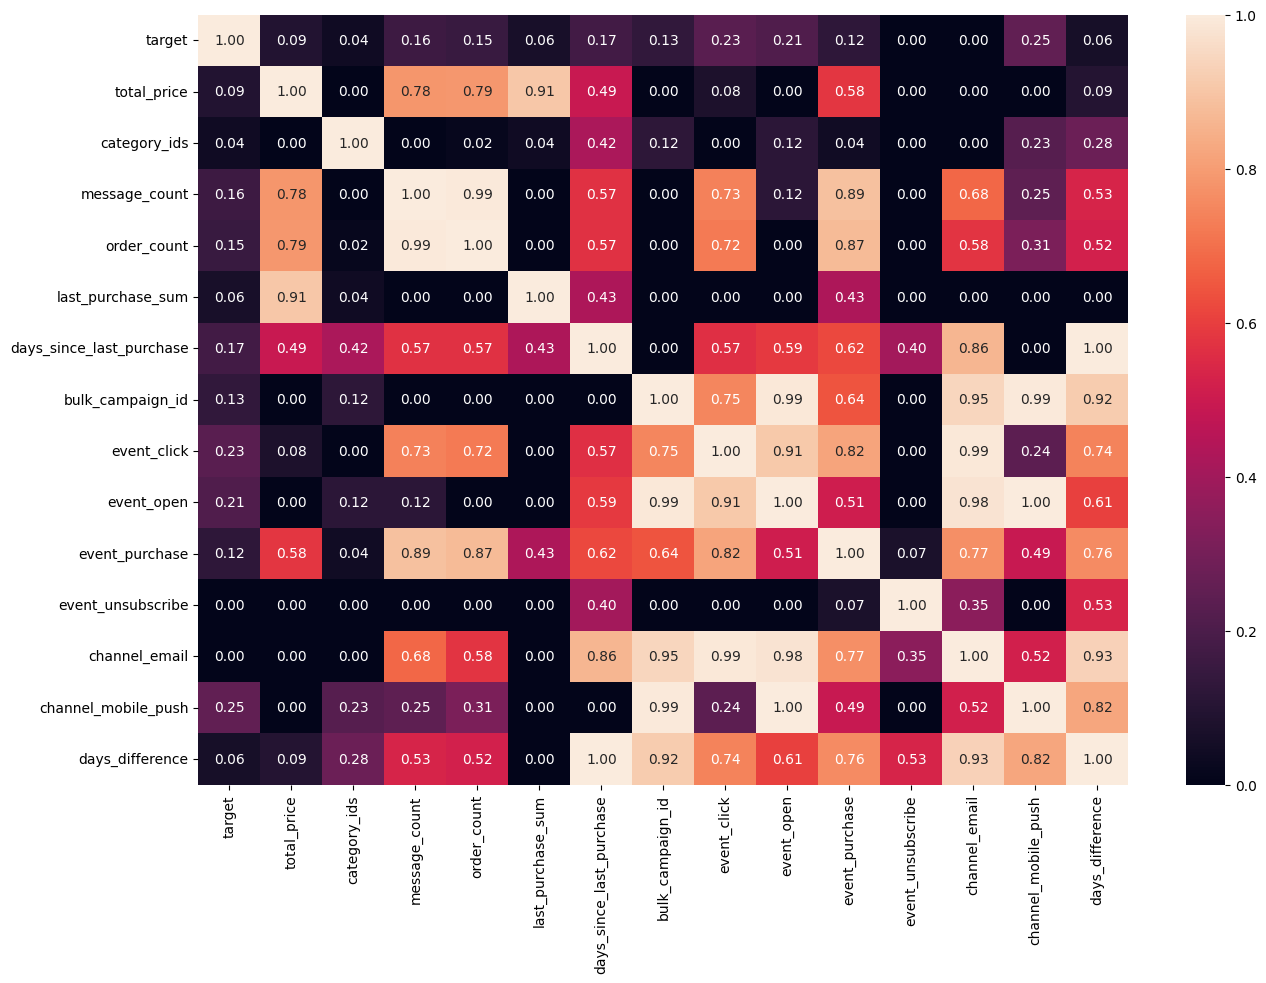

In [84]:


plt.figure(figsize=(15, 10))
sns.heatmap(final_data.sample(10000).phik_matrix(interval_cols=['last_purchase_sum', 'total_price']), annot=True, fmt='.2f')
plt.show()

Интересный момент, что мы имеем совсем низкие коэффициенты между входными признаками и таргетом. Но, возможно, связь имеет нелинейный характер, а матрица корреляции показывает как раз силу линейной зависимости. Тем не менее из всех этих небольших коэффициентов мы можем выделить самые высокие: количество дней с момента последнего заказа, переход по ссылке, открытие письма, пуш-уведомления. Также в матрице можем заметить несколько сильно коррелирующих между собой входных призаков, что говорит нам о их мультиколлинеарности. Мы будем использовать для предсказания модель градиентного бустинга Catboost, которая устойчива к мультиколлинеарности, так как в ёё основе лежат модели деревьев решений. Так что мы оставим все признаки и посмотрим на результаты.

## Обучение моделей

Надо особенно обратить внимание на то, что в целевом признаке очень сильный дисбаланс. 0 класс (клиент не совершит покупку в теч.90 дней) составляет 98% всей выборки. Конечно это будет очень сильно затруднять работу модели, в особенности при предсказании 1 класса. Чтобы хоть как то повлиять на это, при разбивке наших данных на тренировочную и тестовую выборки мы сохраним этот баланс с помощью стратификации. Также при инициализации модели мы укажем веса каждого класса.

In [85]:
RANDOM_STATE = 42
TEST_SIZE = 0.20

# Разбиваем выборку на тренировочную и тестовую, попутно разделяя входные и целевой признак
X_train, X_test, y_train, y_test = train_test_split(
    final_data.drop(
        [
            'target'
        ],
        axis=1
    ),
    final_data['target'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = final_data['target']
)

In [86]:
cat_features = ['category_ids']

# Модель CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,  # количество итераций
    learning_rate=0.01,  # скорость обучения
    depth=5,  # глубина дерева
    loss_function='Logloss',  # функция потерь
    random_seed=RANDOM_STATE,
    class_weights=[0.02, 0.98], # веса классов
    verbose=False,
    cat_features = cat_features
)

# Обучение модели
model.fit(X_train, y_train)


# Предсказания
y_pred_classes = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Метрики
f1 = f1_score(y_test, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"F1-score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

F1-score: 0.099
ROC-AUC: 0.753


F1-score = 0.099: Это очень низкий F1-score. F1-score представляет собой среднее гармоническое между precision (точностью) и recall (полнотой). Низкий F1-score означает, что модель имеет низкую точность или низкую полноту, или и то, и другое. ROC-AUC = 0.753: Значение ROC-AUC 0.753 указывает на умеренную способность модели различать положительный и отрицательный классы. Значение 0.5 соответствует случайному угадыванию, а 1.0 — идеальной классификации. 0.753 лучше, чем случайное угадывание, но далеко от идеального результата.

Построим confusion matrix. Это таблица, которая используется для оценки производительности модели классификации. Она показывает количество истинных положительных, истинных отрицательных, ложноположительных и ложноотрицательных предсказаний, сделанных моделью.

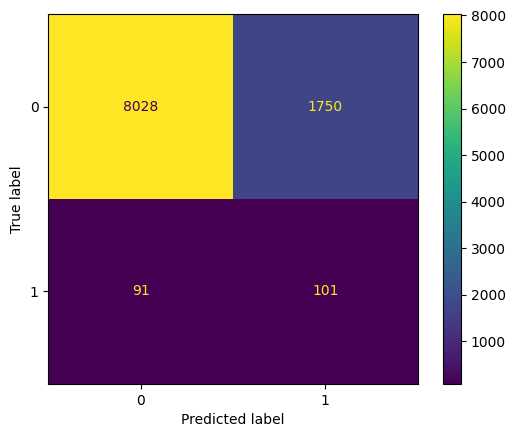

In [87]:
# Получаем предсказания в виде классов
y_test_pred_classes = model.predict(X_test)

# Строим confusion matrix
cm = confusion_matrix(y_test, y_test_pred_classes)

# Визуализируем confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()
plt.show()

1. TP (True Positives) = 101: Модель правильно предсказала 101 случай из положительного класса.
2. TN (True Negatives) = 8028: Модель правильно предсказала 8028 случаев из отрицательного класса.
3. FP (False Positives) = 1750: Модель ошибочно предсказала положительный класс в 1750 случаях, когда на самом деле был отрицательный класс. Это очень много.
4. FN (False Negatives) = 91: Модель ошибочно предсказала отрицательный класс в 91 случае, когда на самом деле был положительный класс.


Количество наблюдений в нулевом классе (8028 + 1750 = 9778) намного больше, чем в положительном (101 + 91 = 192). Это существенно влияет на метрики и может приводить к высокой точности, но низкой полноте. Модель может просто предсказывать отрицательный класс для всех наблюдений и достигать высокой точности, но совершенно игнорируя положительный класс. Поэтому для нашей задачи предсказания нулевого класса можно было и не создавать дополнительные признаки. Модель тогда практически все предсказания относит к нулевому классу. Но вполне возможно,что и клиентам, собирающимся вернуться в ближайшее время с покупкой (1 класс), тоже можно сделать какие то предложения, которые потенциально могут увеличить сумму покупки.

## Анализ важности признаков

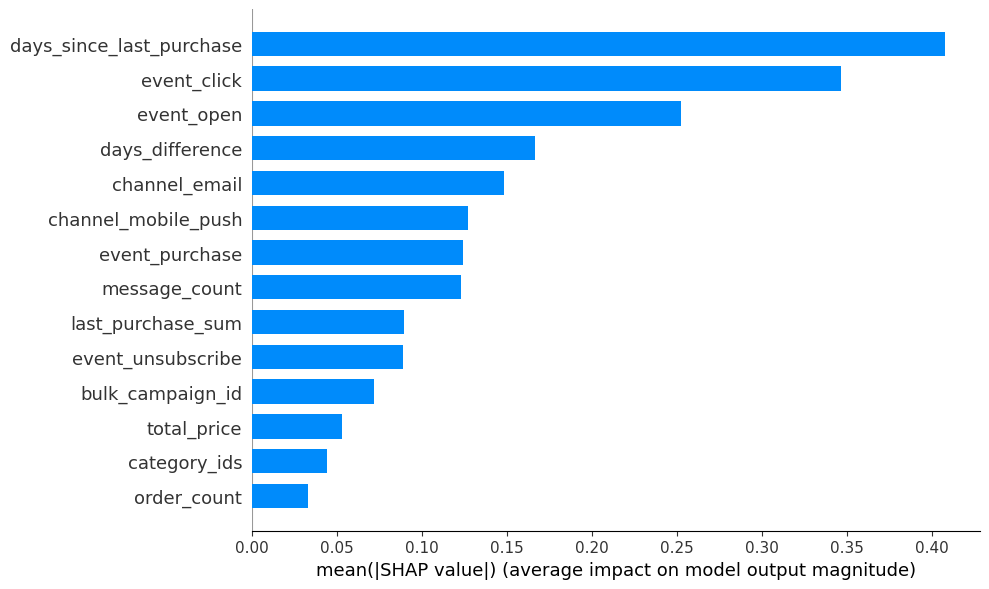

In [88]:
# SHAP values
explainer = shap.Explainer(model) # используем модель прямо
shap_values = explainer(X_train) # используем тренировочную выборку

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="bar", plot_size=(10, 6), show=False)
plt.tight_layout()
plt.show()

Самым важным признаком для нашей моедли оказался созданный нами признак - количество дней с момента последнего заказа, что выглядит вполне логично для цели предсказания. также на первых ролях - переход по ссылке и открытие письма рассылки, разница дней между последним письмом рассылки и последней покупкой клиента. А вот общая потраченная сумма, категории товаров и количество заказов клиента имеют крайне слабое влияние на принятие решения моделью - это всё также созданные нами признаки.

## Выводы

__Итак, в нашем распоряжении было 3 датафрейма для того, чтобы предсказать, совершит ли покупку клиент в течении 90 дней: данные о покупках, данные о маркетинговых рассылках и сам таргет. Данных в исходном виде было недостаточно для работы модели, поэтому после небольшой предобработки и исследования существующих признаков, необходимо было придумать и добавить дополнительные. Как оказалось, некоторые из них были полезными, а некоторые оказались малоинформативными для модели.__
__Проект показал неоднозначные результаты. Модель демонстрирует умеренную способность различать классы (ROC-AUC = 0.753), но F1-score (0.099) чрезвычайно низкий, что указывает на серьезные проблемы с точностью или полнотой, или обоими показателями одновременно. Анализ матрицы ошибок выявил высокое количество ложноположительных результатов (FP = 1750), что значительно больше, чем истинно положительных (TP = 101). Это свидетельствует о дисбалансе классов (значительно больше наблюдений в нулевом классе). При таком дисбалансе несложно с очень большой точностью предсказать этот нулевой класс особенно не задумываясь о новых признаках, но при этом первый класс будет определяться совсем плохо.__

__Важно отметить, что наиболее значимыми признаками оказались количество дней с момента последнего заказа, взаимодействие с email-рассылкой (переход по ссылке и открытие письма), и разница дней между последним письмом и последней покупкой. Это подтверждает логическую связь между недавней активностью клиента и его вероятностью совершить повторную покупку. Напротив, общая потраченная сумма, категории товаров и количество заказов показали крайне слабое влияние на предсказания модели.__